In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import os
import tensorflow as tf

<h1>Project Outline</h1>

The goal of this project is to take in images of plants and output phenotypic characteristics such as leaf count. The motivation is to create something that is useful for processes like high throughput screening. In order to grow food to feed the world's population we are going to need innovative solutions. A tool like this could help a food engineer/geneticist accelerate the speed at which they develop new genetically modified foods.

<h2>Image Data</h2>

I'm using the <a href="https://www.plant-phenotyping.org/datasets-home">CVPPP2017_LSC_training dataset </a> from the International Plant Phenotyping Network. It contains 4 images for 128 plants. Each plant has a "centers", "fg", "label", and "rgb" image. Respectively, these images displays the centerpoint of each leaf, the foreground, each leaf in a different colour, and the raw rgb image of the plant. The plants are from the Arabidopsis family, a commonly studied plant and the first plant to have it's entire genome sequenced. The photos are bird's eye and taken at the same stage in each plant's lifecycle. 

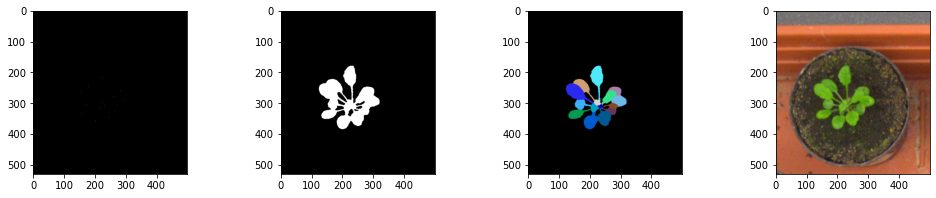

In [2]:
centers = cv2.imread("A1/plant001_centers.png",1)
fg = cv2.imread("A1/plant001_fg.png",1)
label = cv2.imread("A1/plant001_label.png",1)
rgb = cv2.imread("A1/plant001_rgb.png",1)
rgb = cv2.cvtColor(rgb,cv2.COLOR_BGR2RGB)

fig,ax = plt.subplots(1,4,figsize=(17,3))
ax[0].imshow(centers);
ax[1].imshow(fg);
ax[2].imshow(label);
ax[3].imshow(rgb);

<H3>Approach 1: Separate background & foreground manually</H3>

Steps:
- Median blur
- Grayscale
- Binary threshold
- Find contours

In [3]:
def show(image,channels):
    if channels == 1:
        plt.imshow(image,cmap="gray")
    elif channels == 3:
        plt.imshow(image)

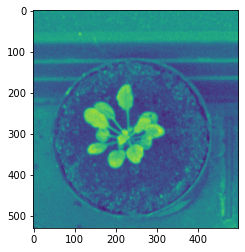

In [4]:
#read image, splits into r,g,b colour channels and isolate g
img = cv2.imread("A1/plant001_rgb.png",1)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
r,g,b = cv2.split(img)
show(g,3)

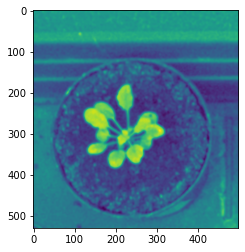

In [5]:
#blur image to remove noise
blurred = cv2.GaussianBlur(g,(5,5),10)
show(blurred,3)

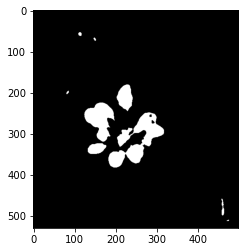

In [6]:
#threshold the image into black and white
thresh,new_img = cv2.threshold(blurred,140,255,cv2.THRESH_BINARY)
show(new_img,1)

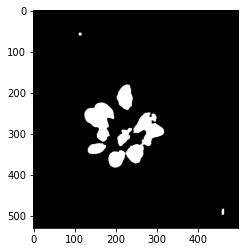

In [7]:
#remove noise from thresholded image
kernel = np.ones((3,3),np.uint8)
opening=cv2.morphologyEx(new_img,cv2.MORPH_OPEN,kernel,iterations=2)
show(opening,1)

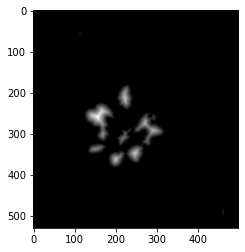

In [8]:
#Create new distance transformed image
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
show(dist_transform,1)

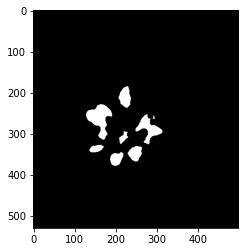

In [9]:
#Apply another threshold to give us an image that is definitely fg
thresh,sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
show(sure_fg,1)

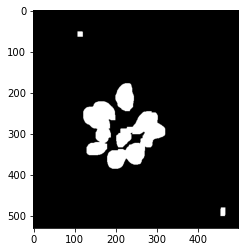

In [10]:
#Use dilate to give us an image that is definitely background
sure_bg = cv2.dilate(opening,kernel,iterations=3)
show(sure_bg,1)

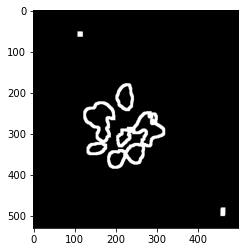

In [11]:
#Determine the unknown region
sure_fg = np.uint8(sure_fg)
sure_bg = np.uint8(sure_bg)
unknown= cv2.subtract(sure_bg,sure_fg)
show(unknown,1)

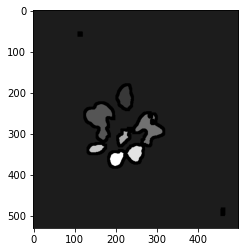

In [12]:
#Use connectedComponents to try and isolate leaves. Add outlines
ret, markers,sizes,centroids = cv2.connectedComponentsWithStats(sure_fg)
markers = markers+1
markers[unknown==255]=0
show(markers,1)

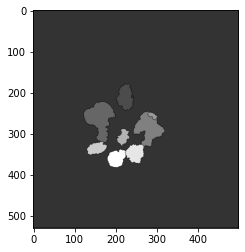

In [13]:
#Use watershed algorithm try and isolate objects that are in contact
markers = cv2.watershed(img,markers)
show(markers,1)

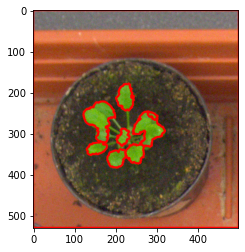

In [14]:
#Add contours to original image
contours,hierarchy = cv2.findContours(markers.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
img2 = img.copy()

for i in range(len(contours)):
    if hierarchy[0][i][3]==-1:
        cv2.drawContours(img2,contours,i,(255,0,0),2)
        
show(img2,3)

In [48]:
#Count how many leaves the system guessed, compare to real answer
leaves_guess = centroids.shape
leaves_guess = leaves_guess[0]

a1_data = pd.read_csv("A1/A1.csv",header=None,names=["Image","Leaves"])
leaves_true = a1_data.loc[a1_data['Image'] == "plant001_rgb.png", 'Leaves']
leaves_true = leaves_true[0]

print("Guessed amount of leaves: ",leaves_guess)
print("True amount of leaves: ",leaves_true)

Guessed amount of leaves:  9
True amount of leaves:  15


<h2>Results</h2>

I'm pretty happy with the output image, it was really fun to learn how to manipulate an image, perform operations on it, and output something that makes decent sense. Obviously the quantitative result is not the greatest, 9 leaves vs 15 (giving only 60% accuracy). I ran this on a series of other images and they were all in a similar ball park. The program does a great job of identifying the plant but doesn't do a great job at segmenting the leaves from each other. 


<h2>Approach 2: Build a CNN to predict # of leaves</h2>

In [49]:
from keras.models import Sequential
from keras.layers import Activation,Dropout,Flatten,Conv2D,MaxPooling2D,Dense

In [61]:
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=np.shape(img),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=np.shape(img),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=np.shape(img),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))
#need to reduce output to a single number, the leaf guess
model.add(Dense(1))
model.add(Activation('relu'))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])

In [62]:
model.summary()
#need to process data here. How to create a data structure with all the images and the amount of leaves

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 528, 498, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 264, 249, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 262, 247, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 131, 123, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 129, 121, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 60, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 245760)           

In [65]:
#test on 22 data points, train on the rest (106)
data = pd.read_csv("Data/A1.csv")
train_y = data["Leaves"]
train_y = np.array(train_y[22:])
test_y = data["Leaves"]
test_y = np.array(test_y[:22])
data.head()

,Plant,Leaves
0,plant001_rgb.png,15
1,plant002_rgb.png,11
2,plant005_rgb.png,15
3,plant006_rgb.png,15
4,plant007_rgb.png,12


In [68]:
#reshape to make sure input matches what CNN is expecting
test_y = test_y.reshape(22,1)
train_y = train_y.reshape(106,1)
np.shape(train_y)

(106, 1)

In [70]:
#function to return array with images
def load_img(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [72]:
#load test images 
folder = "Data/Test"
test_x = load_img(folder)
test_x = np.true_divide(test_x,255)

In [73]:
#load train images
folder = "Data/Train"
train_x = load_img(folder)
np.shape(train_x)
train_x = np.true_divide(train_x,255)

In [74]:
#fit model on 10 epochs
model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=10)

Epoch 1/10
4/4 [==============================] - 19s 5s/step - loss: 236.4346 - mean_squared_error: 236.4346 - val_loss: 134.4657 - val_mean_squared_error: 134.4657
Epoch 2/10
4/4 [==============================] - 15s 4s/step - loss: 76.8383 - mean_squared_error: 76.8383 - val_loss: 10.4253 - val_mean_squared_error: 10.4253
Epoch 3/10
4/4 [==============================] - 15s 4s/step - loss: 24.2868 - mean_squared_error: 24.2868 - val_loss: 4.1479 - val_mean_squared_error: 4.1479
Epoch 4/10
4/4 [==============================] - 14s 3s/step - loss: 16.7184 - mean_squared_error: 16.7184 - val_loss: 3.1080 - val_mean_squared_error: 3.1080
Epoch 5/10
4/4 [==============================] - 13s 3s/step - loss: 12.7568 - mean_squared_error: 12.7568 - val_loss: 3.2483 - val_mean_squared_error: 3.2483
Epoch 6/10
4/4 [==============================] - 13s 3s/step - loss: 10.2796 - mean_squared_error: 10.2796 - val_loss: 3.5455 - val_mean_squared_error: 3.5455
Epoch 7/10
4/4 [================

In [75]:
model.evaluate(test_x,test_y)

1/1 [==============================] - 0s 992us/step - loss: 3.8057 - mean_squared_error: 3.8057


[3.8057401180267334, 3.8057401180267334]

In [76]:
model.predict(test_x)

array([[13.409975 ],
       [13.446637 ],
       [14.508755 ],
       [13.357548 ],
       [13.293604 ],
       [14.306345 ],
       [14.511408 ],
       [13.302168 ],
       [13.233901 ],
       [12.887962 ],
       [14.344144 ],
       [13.755485 ],
       [13.494408 ],
       [12.963858 ],
       [14.003977 ],
       [13.853922 ],
       [13.038258 ],
       [14.909082 ],
       [14.1768265],
       [13.335714 ],
       [15.398806 ],
       [15.863596 ]], dtype=float32)

<h2>Preliminary Results</h2>

Model achieved MSE of 3.8057. If we guessed the number of leaves were equal to the mean (16.31) our MSE would be 7.1016. This is good news, that the CNN outperformed guessing the mean but that is a pretty low bar to pass. 


<h2>Future Improvments</h2>

- Check the standard deviation to see if the data is normally distributed (then make appropriate adjustments to balance out the dataset
- Improve random sampling of data and build it into a more repeatable function
- Add rounding so that the CNN guess discrete amounts of leaves
- Add cross validation to reduce chances of selection bias and overfitting
- Alternate method: train a neural net to build a foreground image. Then use kmeans to estimate amount of leaves in that foreground image. Since we have data for the centroids of each leaf, this should produce a pretty accurate model.